# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
import scipy.signal as signal
import random
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

# Задание окружения

In [2]:
figures = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "2023-Project-112", "figures")

# Работа с данными

## Видеоряд

In [3]:
video_path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "src", "Film stimulus.mp4")

In [4]:
def video_to_frames():
    videocap = cv2.VideoCapture(video_path)
    success, frame = videocap.read()
    count = 1
    while success:
        cv2.imwrite(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                                "src", "frames", f"frame_{count}.jpg"), frame)    
        success, frame = videocap.read()
        count += 1

In [5]:
frame_path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "frames", f"frame_{1}.jpg")
frame = Image.open(frame_path)

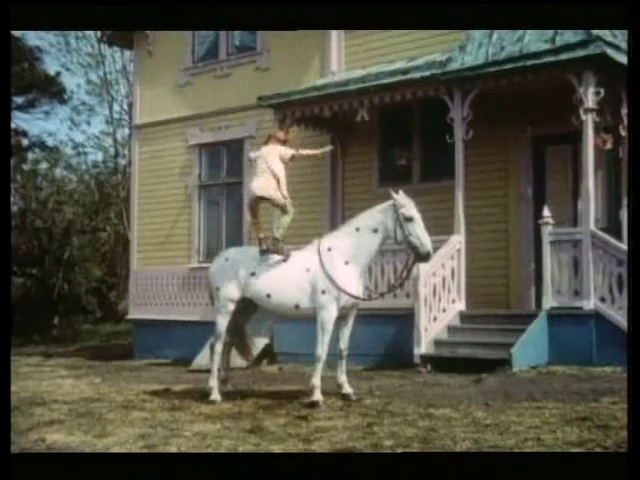

In [6]:
frame

In [8]:
# меняем frames_to_tensors()

def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        transformer = transforms.ToTensor()
        frame_tensor = transformer(frame)
        yield frame_tensor

In [9]:
# меняем tensors_to_vectors()

def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        vector = frame_tensor.numpy().flatten()
        yield vector

In [10]:
vector_list = [vector for vector in tensors_to_vectors()]

## Снимки фМРТ

In [11]:
class Sub:

    subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',\
                  '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',\
                  '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

    def __init__(self, number):
        if not number in Sub.subs_with_fmri:
            raise ValueError(f"У {number} испытуемого отсутствуют снимки фМРТ")
        else:
            self.number = number
        self.path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "ds003688-download", f"sub-{self.number}",\
                                    "ses-mri3t", "func", f"sub-{self.number}_ses-mri3t_task-film_run-1_bold.nii.gz")
        self.scan = nib.load(self.path)
        self.data = self.scan.get_fdata()
        self.tensor = torch.tensor(self.data)
        self.tensor_np = self.tensor.numpy()

# Построение линейной модели

In [12]:
class Preprocessor:

    def __init__(self, sub, dt, coef, train_size=0.7):
        self.sub = sub
        self.dt = dt
        self.coef = coef
        self.train_size = train_size

        self.nu = 25 # частота видео
        self.mu = 641. / 390. # частота снимков фМРТ
        self.d1 = self.sub.tensor.shape[0] # размерности снимка фМРТ до сжатия
        self.d2 = self.sub.tensor.shape[1]
        self.d3 = self.sub.tensor.shape[2]
        self.d4 = self.sub.tensor.shape[3]
        self.d = 2048 # длина вектора признакового описания изображения
        self.N = 641 - int(self.mu * self.dt) # N - количество снимков фМРТ

        self.train, self.test = self.get_train_test()

    @staticmethod
    def preprocess(v):
        return (v - v.min()) / (v.max() - v.min())

    @staticmethod
    def MSE(A):
        m, n = A.shape
        return (np.linalg.norm(A, "fro") ** 2) / (m * n)

    def get_train_test(self):
        pairs = [(int(i * self.nu / self.mu), int(self.mu * self.dt + i)) for i in range(self.N)] # (номер изображения, номер снимка)

        if (self.coef > 1): # сжатие снимка фМРТ
            maxpool = torch.nn.MaxPool3d(kernel_size=self.coef, stride=self.coef)
            input_tensor = self.sub.tensor.permute(3, 0, 1, 2)
            output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
            self.sub._tensor = output_tensor
        else:
            self.sub._tensor = self.sub.tensor
        
        self._d1 = self.sub._tensor.shape[0]
        self._d2 = self.sub._tensor.shape[1]
        self._d3 = self.sub._tensor.shape[2]
        self._d4 = self.sub._tensor.shape[3]
        
        scans_list = [self.sub._tensor[:, :, :, i] for i in range(self.d4)] # список тензоров снимков фМРТ
        voxels = [scan.reshape(self._d1 * self._d2 * self._d3).numpy() for scan in scans_list] # список снимков фМРТ, развернутых в векторы
        data = [(vector_list[n], voxels[k]) for n, k in pairs] # (изображение, снимок)

        # train, test
        l = int(self.train_size * self.d4) # размер обучающей выборки
        train, test = data[:l], data[l:]
            
        train = [(pair[0], self.preprocess(pair[1])) for pair in train]
        test = [(pair[0], self.preprocess(pair[1])) for pair in test]

        return train, test
    

## Предсказание разницы между снимками

In [14]:
class LinearDeltaPredictor(Preprocessor):
    def __init__(self, sub, dt, coef, alpha, train_size=0.7):
        super().__init__(sub, dt, coef, train_size)
        self.delta = True
        self.alpha = alpha
        self.X_train, self.Y_train, self.deltaY_train, self.X_test, self.Y_test, self.deltaY_test = self.get_XY()

    def get_XY(self):
        delta_train = [(self.train[n][0], self.train[n][1] - self.train[n-1][1]) for n in range(1, len(self.train))]
        delta_test = [(self.test[n][0], self.test[n][1] - self.test[n-1][1]) for n in range(1, len(self.test))]
        Y_train = np.array([pair[1] for pair in self.train]).T
        Y_test = np.array([pair[1] for pair in self.test]).T
        X_train = np.array([pair[0] for pair in delta_train])
        deltaY_train = np.array([pair[1] for pair in delta_train]).T
        X_test = np.array([pair[0] for pair in delta_test])
        deltaY_test = np.array([pair[1] for pair in delta_test]).T
        return X_train, Y_train, deltaY_train, X_test, Y_test, deltaY_test

    def predict(self):
        W = [] # матрица весов модели

        if (self.alpha > 0):
            A = np.linalg.inv(self.X_train.T @ self.X_train + self.alpha * np.identity(self.X_train.shape[1])) @ self.X_train.T
        else:
            A = np.linalg.pinv(self.X_train)
        
        for i in range(self._d1 * self._d2 * self._d3):
            deltaY_train_vector = self.deltaY_train[i]
            w = A @ deltaY_train_vector
            W.append(w)
            
        self.W = np.array(W) # w будут строками

        self.deltaY_train_predicted = self.W @ self.X_train.T
        self.deltaY_test_predicted = self.W @ self.X_test.T
        self.Y_train_predicted = np.delete(self.Y_train, -1, 1) + self.deltaY_train_predicted
        self.Y_test_predicted = np.delete(self.Y_test, -1, 1) + self.deltaY_test_predicted
    
        self.MSE_train = self.MSE(self.Y_train_predicted - np.delete(self.Y_train, 0, 1))
        self.MSE_test = self.MSE(self.Y_test_predicted - np.delete(self.Y_test, 0, 1))

# Пример работы

In [15]:
sub = Sub('04')

In [16]:
lindeltapred = LinearDeltaPredictor(sub, 5, 1, 0)

In [17]:
lindeltapred.X_train.shape

(447, 921600)

In [22]:
lindeltapred.deltaY_train.T.shape

(447, 163840)

$$
\begin{aligned}
    X &= \mathrm{X\_train} \\
    y &= \mathrm{deltaY\_train\_vector} \\
    f(w) &= \| Xw - y \|_2^2 \\
    \nabla f(w) &= 2 X^\top (Xw - y) \\
    \nabla^2 f(w) &= 2 X^\top X
\end{aligned}
$$

In [95]:
X = lindeltapred.X_train
y = lindeltapred.deltaY_train[307]
w = np.zeros(X.shape[1])

In [96]:
X.shape

(447, 921600)

In [97]:
np.linalg.matrix_rank(X)

9

In [32]:
447/9

49.666666666666664

In [31]:
921600/447

2061.7449664429532

In [98]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2

In [131]:
def df(w, X=X, y=y):
    return 2 * X.T @ (X @ w - y)

In [50]:
def d2f(w):
    return 2 * X.T @ X

In [36]:
d2f(w)

MemoryError: Unable to allocate 3.09 TiB for an array with shape (921600, 921600) and data type float32

ПРОБЛЕМА! Несмотря на то, что задача, очевидно, является $L$-гладкой, найти точное значение $L$ не представляется возможным.

---

#### Градиентный спуск с постоянным шагом

In [100]:
def GD(w0, h=1e-2, max_iter=1000):
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        w = w - h * df(w)
        f_log.append(f(w))
    return w, f_log

In [228]:
w0 = np.zeros(X.shape[1])
h = 1e-8
max_iter = 100

w_GD, f_log_GD = GD(w0, h, max_iter)

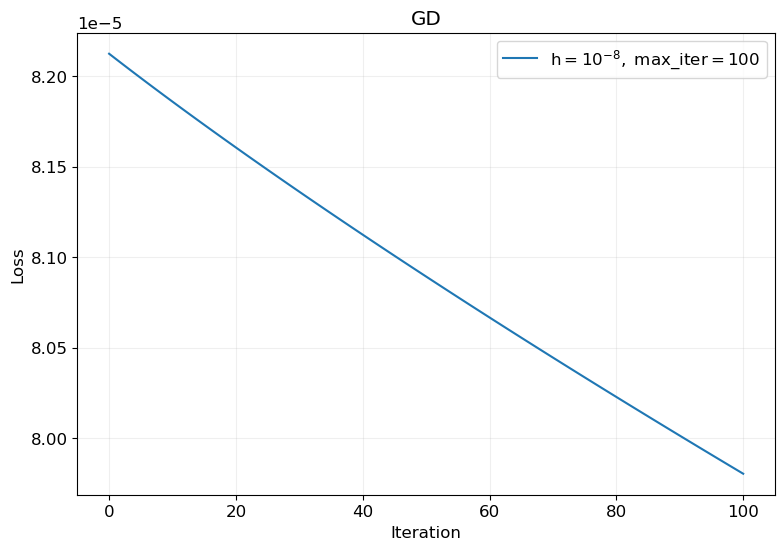

In [324]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_GD, label=r'$\mathrm{h = 10^{-8}, \ max\_iter = 100}$')
plt.title(f'GD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('gd.pdf', bbox_inches='tight')

---

#### Градиентный спуск с подбором шага по правилу Армихо

In [114]:
def Armijo(w, h0=1, alpha=0.3, rho=0.5):
    h = h0
    g = df(w)
    while f(w - h * g) > f(w) - alpha * h * g.T @ df(w):
        h = rho * h
    return h

In [115]:
def GD_Armijo(w0, max_iter=1000):
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        h = Armijo(w)
        w = w - h * df(w)
        f_log.append(f(w))
    return w, f_log

In [116]:
w0 = np.zeros(X.shape[1])
max_iter = 100

w_GD_Armijo, f_log_GD_Armijo = GD_Armijo(w0, max_iter)

KeyboardInterrupt: 

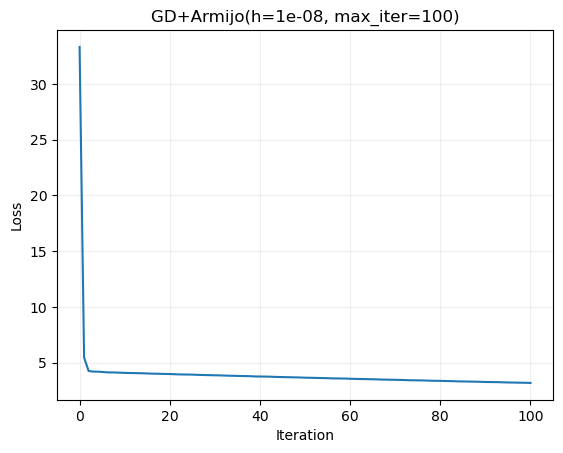

In [ ]:
plt.plot(f_log_GD_Armijo)
plt.title(f'GD+Armijo(max_iter={max_iter})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)

---

#### Стохастический градиентный спуск

In [139]:
def SGD(w0, h=1e-6, max_iter=1000):
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    n_samples, n_features = X.shape
    while len(f_log) <= max_iter:
        for _ in range(n_samples):
            i = np.random.randint(n_samples)
            g = 2 * X[i] * (X[i] @ w - y[i])
            w = w - h * g
        f_log.append(f(w))
    return w, f_log

In [127]:
f(w0)

8.212374468724937e-05

In [128]:
df(w0)

array([ 5.35642548e-06,  7.54500265e-06, -1.24535764e-05, ...,
       -4.82267143e-06, -9.06721483e-06, -1.43467067e-05])

In [320]:
w0 = np.zeros(X.shape[1])
h = 1e-6
max_iter = 1000

w_SGD, f_log_SGD = SGD(w0, h, max_iter)

KeyboardInterrupt: 

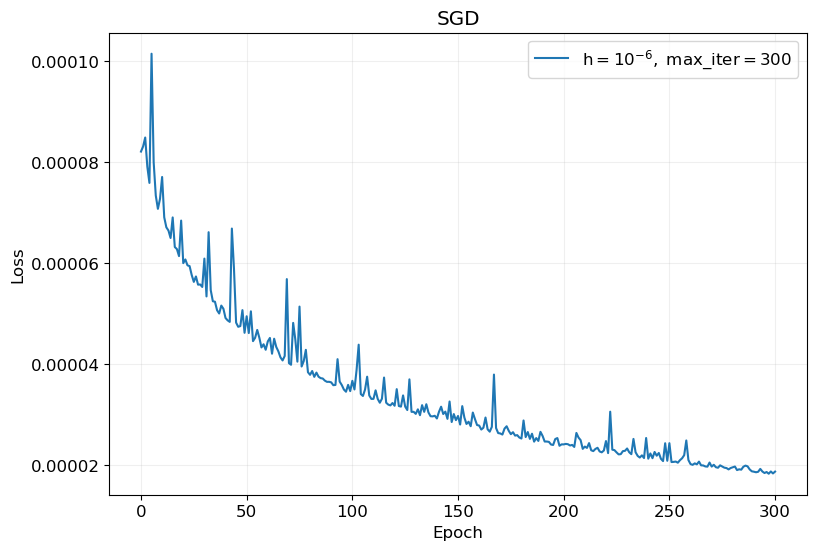

In [327]:
plt.figure(figsize=(9, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(f_log_SGD, label=r'$\mathrm{h = 10^{-6}, \ max\_iter = 300}$')
plt.title(f'SGD')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('sgd.pdf', bbox_inches='tight')

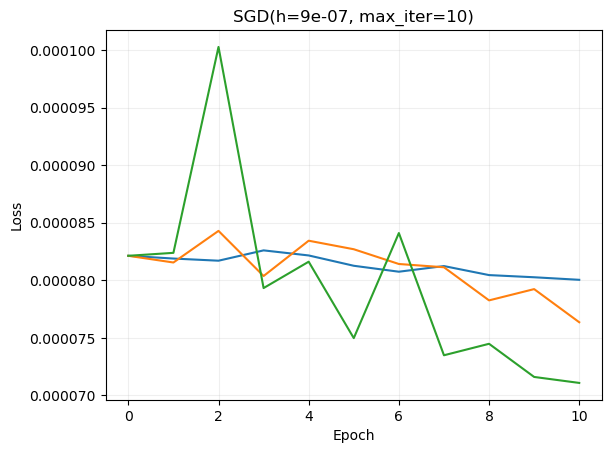

In [152]:
w0 = np.zeros(X.shape[1])
hs = [1e-7, 3e-7, 9e-7]
max_iter = 10

for h in hs:
    w_SGDh, f_log_SGDh = SGD(w0, h, max_iter)
    plt.plot(f_log_SGDh)
    plt.title(f'SGD(h={h}, max_iter={max_iter})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.2)

plt.show()

Градиентные покомпонентные методы (coordinate gradient descent methods) - это класс оптимизационных методов, которые на каждой итерации обновляют только одну компоненту вектора параметров, выбирая ее по какому-то правилу.

В общем случае градиентные покомпонентные методы могут быть применены к произвольной функции $f(w)$, но чаще всего они используются для решения задачи минимизации выпуклых функций. В этом случае алгоритм заключается в последовательном обновлении каждой компоненты вектора параметров $w$:

$$
w_i^{(t+1)} = w_i^{(t)} - \alpha_t \frac{\partial f(w)}{\partial w_i} \bigg|_{w_i=w_i^{(t)}, w_j=w_j^{(t)}, j\neq i}
$$

где $i$ - индекс компоненты, которую мы обновляем, $\alpha_t$ - длина шага на $t$-ой итерации.

Существует несколько способов выбора индекса $i$ на каждой итерации. Например, в методе координатного спуска (coordinate descent) индекс $i$ выбирается циклически, т.е. $i=1$ на первой итерации, затем $i=2$ на второй итерации и т.д. Другой подход - случайный выбор индекса $i$ на каждой итерации, который используется в методе случайного координатного спуска (random coordinate descent).

Градиентные покомпонентные методы могут быть эффективны в случае, когда функция $f(w)$ имеет разреженную структуру, т.е. зависит только от небольшого числа компонент вектора $w$. В этом случае обновление всех компонент на каждой итерации может быть избыточным и неэффективным.

---

#### Стохастический градиентный спуск с мини-батчами

In [132]:
def MBSGD(w0, h=1e-6, batch=5, max_iter=1000):
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    n_samples, n_features = X.shape
    while len(f_log) <= max_iter:
        for i in range(0, n_samples, batch):
            Xi = X[i:i+batch]
            yi = y[i:i+batch]
            g = df(w, Xi, yi) / Xi.shape[0]
            w = w - h * g
        f_log.append(f(w))
    return w, f_log

In [318]:
w0 = np.zeros(X.shape[1])
h = 1e-6
batch = 10
max_iter = 100

w_MBSGD, f_log_MBSGD = MBSGD(w0, h, batch, max_iter)

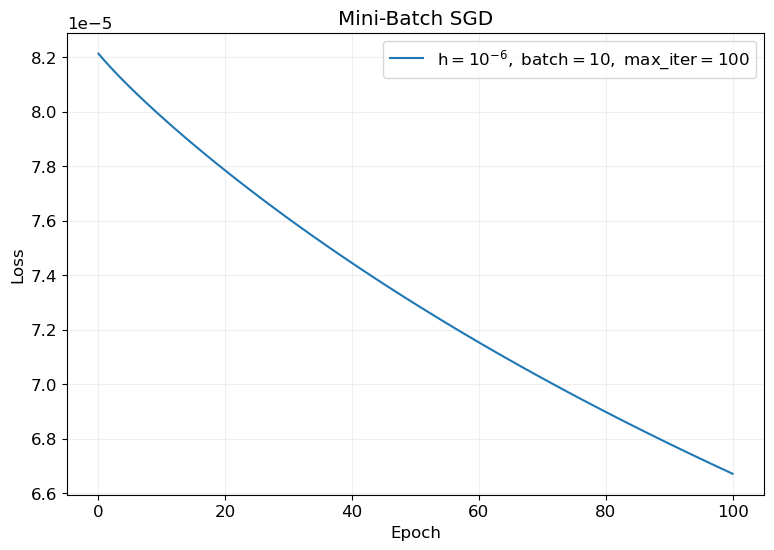

In [328]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_MBSGD, label=r'$\mathrm{h = 10^{-6}, \ batch = 10, \ max\_iter = 100}$')
plt.title(f'Mini-Batch SGD')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('mbsgd.pdf', bbox_inches='tight')

---

#### Покоординатный спуск

In [172]:
def CD(w0, h=1e-6, max_iter=1000):
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    n_samples, n_features = X.shape
    while len(f_log) <= max_iter:
        j = np.random.randint(n_features)
        g = 2 * X[:, j] @ (X @ w - y)
        w[j] = w[j] - h * g
        f_log.append(f(w))
    return w, f_log

In [316]:
w0 = np.zeros(X.shape[1])
h = 1e-3
max_iter = 100

w_CD, f_log_CD = CD(w0, h, max_iter)

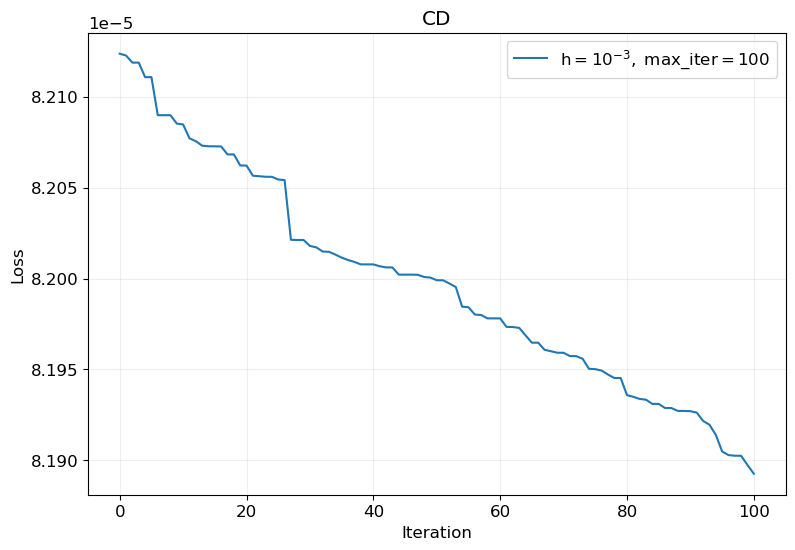

In [329]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_CD, label=r'$\mathrm{h = 10^{-3}, \ max\_iter = 100}$')
plt.title(f'CD')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('cd.pdf', bbox_inches='tight')

---

In [183]:
def df_i(i, w):
    return 2 * X[i] * (X[i] @ w - y[i])

In [299]:
def DorKis(w0, h=1e-6, p=0.7, max_iter=1000):
    lst = [0, 1]
    weights = [0.3, 0.7]  # вероятность выпадения 0 - 30%, вероятность выпадения 1 - 70%
    f_log = []
    w = np.array(w0)
    f_log.append(f(w))
    n_samples, n_features = X.shape
    while len(f_log) <= max_iter:
        way = random.choices(lst, weights=weights)[0]  # выбираем один элемент из списка с заданными вероятностями
        if way == 0: # one SGD epoch
            for _ in range(n_samples):
                i = np.random.randint(n_samples)
                g = 2 * X[i] * (X[i] @ w - y[i])
                w = w - h * g
        else: # GD
            w = w - h * df(w)
        f_log.append(f(w))
    return w, f_log

In [314]:
w0 = np.zeros(X.shape[1])
h = 1e-8
p = 0.7
max_iter = 100

w_DorKis, f_log_DorKis = DorKis(w0, h, p, max_iter)

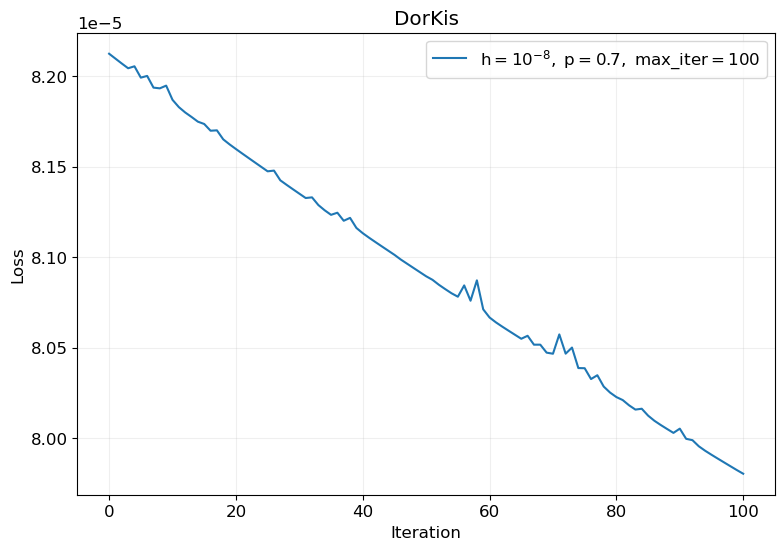

In [330]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_DorKis, label=r'$\mathrm{h = 10^{-8}, \ p = 0.7, \ max\_iter = 100}$')
plt.title(f'DorKis')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('dorkis.pdf', bbox_inches='tight')

---

#### Momentum

In [74]:
def Momentum(w0, alpha=1e-3, beta=0.9, max_iter=1000):
    f_log = []
    v = np.zeros(len(w0))
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        v = beta * v - alpha * df(w)
        w = w + v
        f_log.append(f(w))
    return w, f_log

In [234]:
w0 = np.zeros(X.shape[1])
alpha = 1e-8
beta = 0.9
max_iter = 100

w_Momentum, f_log_Momentum = Momentum(w0, alpha, beta, max_iter)

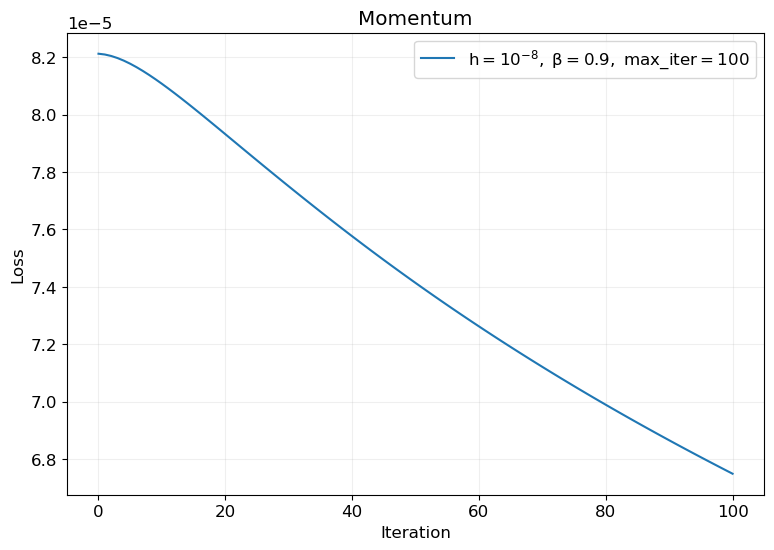

In [331]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_Momentum, label=r'$\mathrm{h = 10^{-8}, \ \beta = 0.9, \ max\_iter = 100}$')
plt.title(f'Momentum')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('momentum.pdf', bbox_inches='tight')

---

#### Nesterov Momentum

In [162]:
def NesterovMomentum(w0, alpha=1e-3, beta=0.9, max_iter=1000):
    f_log = []
    v = np.zeros(len(w0))
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        v = beta * v - alpha * df(w + beta * v)
        w = w + v
        f_log.append(f(w))
    return w, f_log

In [235]:
w0 = np.zeros(X.shape[1])
alpha = 1e-8
beta = 0.9
max_iter = 100

w_NesterovMomentum, f_log_NesterovMomentum = NesterovMomentum(w0, alpha, beta, max_iter)

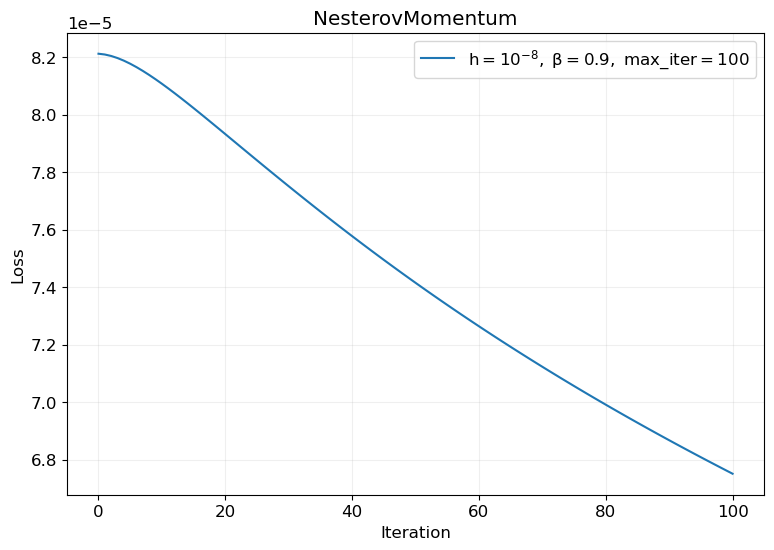

In [332]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_NesterovMomentum, label=r'$\mathrm{h = 10^{-8}, \ \beta = 0.9, \ max\_iter = 100}$')
plt.title(f'NesterovMomentum')
plt.legend()
plt.xlabel('Iteration')
#plt.yscale('log')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('nesterov_momentum.pdf', bbox_inches='tight')

---

#### Adagrad

In [84]:
def Adagrad(w0, alpha=1e-2, eps=1e-8, max_iter=1000):
    f_log = []
    G = np.zeros(len(w0))
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        g = df(w)
        G = G + g ** 2
        w = w - alpha / np.sqrt(G + eps) * g
        f_log.append(f(w))
    return w, f_log

In [240]:
w0 = np.zeros(X.shape[1])
alpha = 1e-8
eps = 1e-8
max_iter = 100

w_Adagrad, f_log_Adagrad = Adagrad(w0, alpha, eps, max_iter)

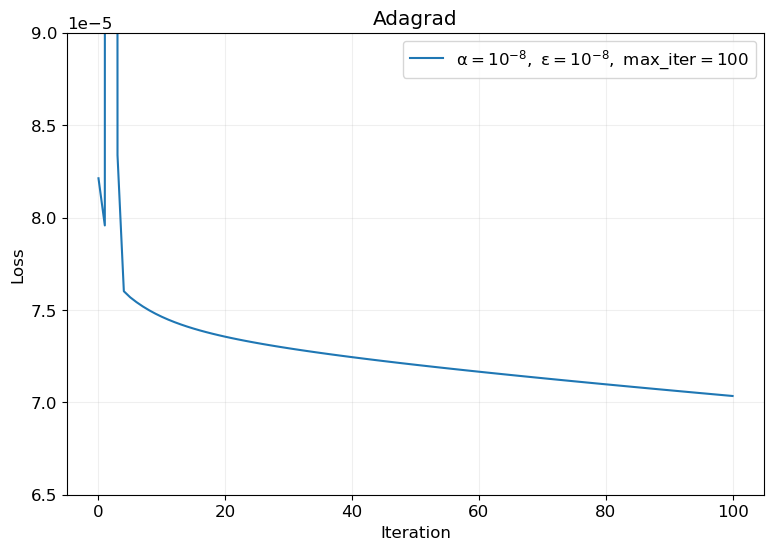

In [333]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_Adagrad, label=r'$\mathrm{\alpha = 10^{-8}, \ \varepsilon = 10^{-8}, \ max\_iter = 100}$')
plt.title(f'Adagrad')
plt.legend()
plt.xlabel('Iteration')
#plt.yscale('log')
plt.ylim(6.5e-5, 9e-5)
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('adagrad.pdf', bbox_inches='tight')

---

#### RMSProp

In [87]:
def RMSProp(w0, alpha=1e-2, gamma=0.9, eps=1e-8, max_iter=1000):
    f_log = []
    G = np.zeros(len(w0))
    w = np.array(w0)
    f_log.append(f(w))
    while len(f_log) <= max_iter:
        g = df(w)
        G = gamma * G + (1 - gamma) * g ** 2
        w = w - alpha / np.sqrt(G + eps) * g
        f_log.append(f(w))
    return w, f_log

In [256]:
w0 = np.zeros(X.shape[1])
alpha = 1e-6
gamma = 0.9
eps = 1e-8
max_iter = 100

w_RMSProp, f_log_RMSProp = RMSProp(w0, alpha, gamma, eps, max_iter)

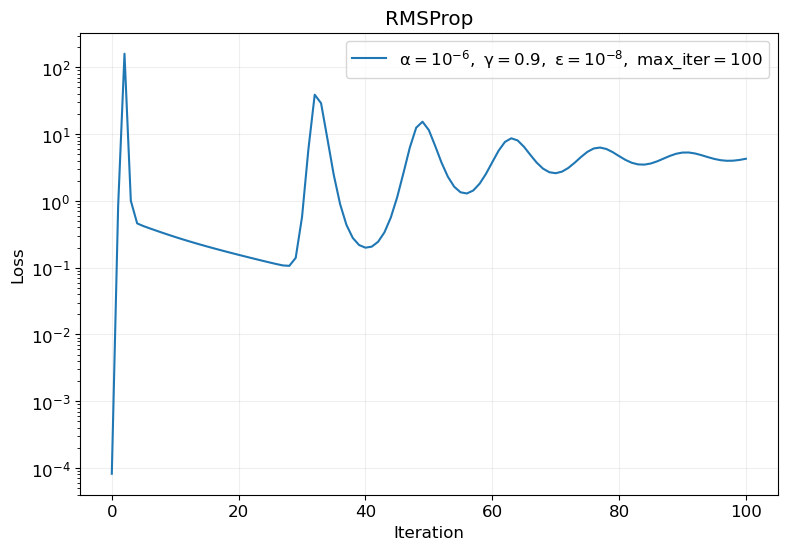

In [334]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_RMSProp, label=r'$\mathrm{\alpha = 10^{-6}, \ \gamma = 0.9, \ \varepsilon = 10^{-8}, \ max\_iter = 100}$')
plt.title(f'RMSProp')
plt.legend()
plt.xlabel('Iteration')
plt.yscale('log')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('rmsprop.pdf', bbox_inches='tight')

---

#### Adam

In [90]:
def Adam(w0, alpha=1e-2, beta_1=0.9, beta_2=0.999, eps=1e-8, max_iter=1000):
    f_log = []
    v = np.zeros_like(w0)
    G = np.zeros_like(w0)
    w = np.array(w0)
    f_log.append(f(w))
    for i in range(1, max_iter+1):
        g = df(w)
        v = beta_1 * v + (1 - beta_1) * g
        G = beta_2 * G + (1 - beta_2) * g ** 2
        v_hat = v / (1 - beta_1 ** i)
        G_hat = G / (1 - beta_2 ** i)
        w = w - alpha / np.sqrt(G_hat + eps) * v_hat
        f_log.append(f(w))
    return w, f_log

In [257]:
w0 = np.zeros(X.shape[1])
alpha = 1e-6
beta_1 = 0.9
beta_2 = 0.999
eps = 1e-8
max_iter = 100

w_Adam, f_log_Adam = Adam(w0, alpha, beta_1, beta_2, eps, max_iter)

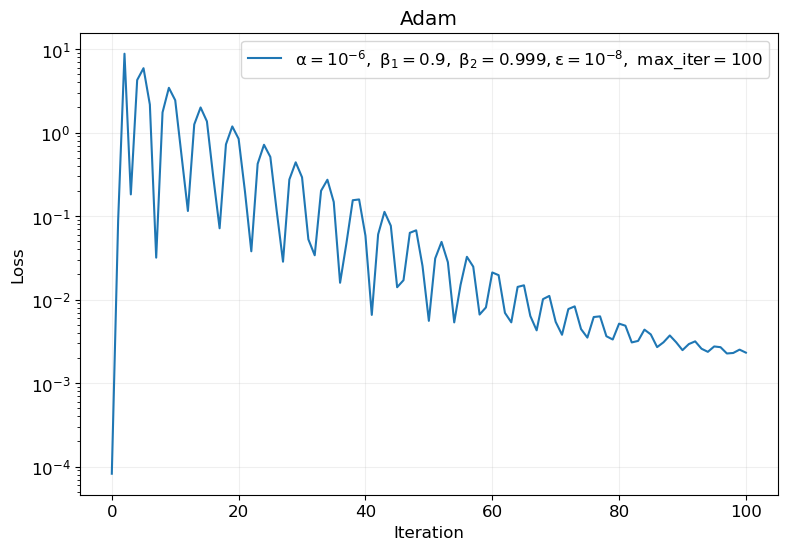

In [335]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_Adam, label=r'$\mathrm{\alpha = 10^{-6}, \ \beta_1 = 0.9, \ \beta_2 = 0.999, \varepsilon = 10^{-8}, \ max\_iter = 100}$')
plt.title(f'Adam')
plt.legend()
plt.xlabel('Iteration')
plt.yscale('log')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('adam.pdf', bbox_inches='tight')

---

#### Сравнение всех методов

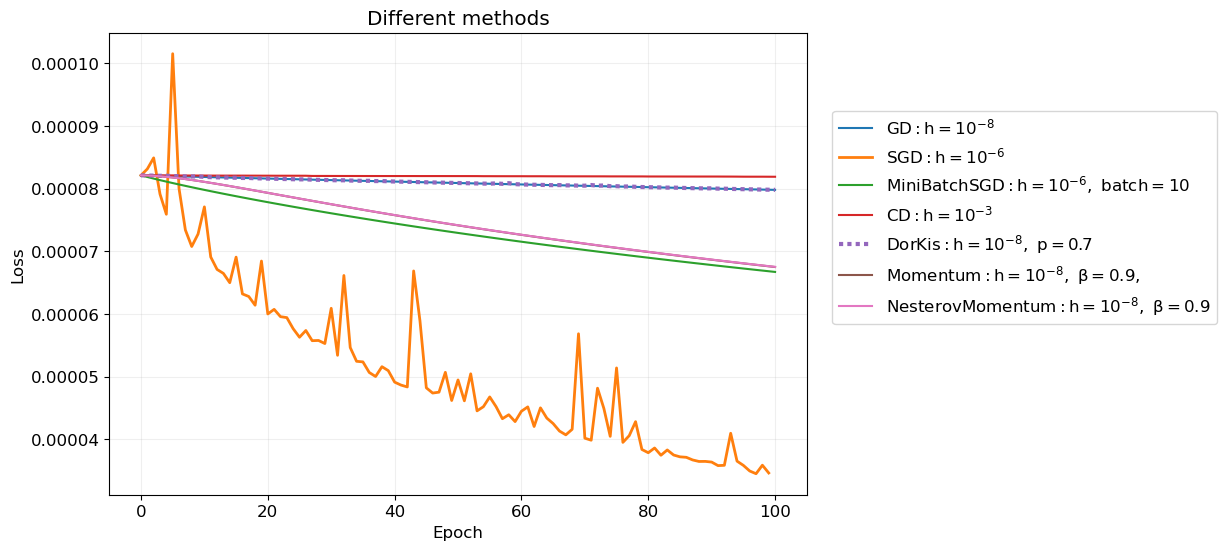

In [382]:
plt.figure(figsize=(9, 6))
plt.plot(f_log_GD, label=r'$\mathrm{GD: h = 10^{-8}}$')
plt.plot(f_log_SGD[:100], linewidth=2, label=r'$\mathrm{SGD: h = 10^{-6}}$')
plt.plot(f_log_MBSGD, label=r'$\mathrm{MiniBatch SGD: h = 10^{-6}, \ batch = 10}$')
plt.plot(f_log_CD, label=r'$\mathrm{CD: h = 10^{-3}}$')
plt.plot(f_log_DorKis, linestyle=(0, (1, 1)), linewidth=3, label=r'$\mathrm{DorKis: h = 10^{-8}, \ p = 0.7}$')
plt.plot(f_log_Momentum, label=r'$\mathrm{Momentum: h = 10^{-8}, \ \beta = 0.9,}$')
plt.plot(f_log_NesterovMomentum, label=r'$\mathrm{NesterovMomentum: h = 10^{-8}, \ \beta = 0.9}$')
#plt.plot(f_log_Adagrad, label=r'$\mathrm{Adagrad: \alpha = 10^{-8}, \ \varepsilon = 10^{-8}}$')
#plt.plot(f_log_RMSProp, label=r'$\mathrm{RMSProp: \alpha = 10^{-6}, \ \gamma = 0.9, \ \varepsilon = 10^{-8}}$')
#plt.plot(f_log_Adam, label=r'$\mathrm{Adam: \alpha = 10^{-6}, \ \beta_1 = 0.9, \ \beta_2 = 0.999, \varepsilon = 10^{-8}}$')
plt.title(f'Different methods')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor = (1.6, 0.6), loc='center right')
#plt.yscale('log')
plt.ylabel('Loss')
plt.grid(alpha=0.2)
plt.savefig('different_methods.pdf', bbox_inches='tight')

---

# Toy problem

In [30]:
from sklearn.datasets import make_regression

In [37]:
X, y = make_regression(n_samples=100, n_features=200000, n_informative=2)

In [46]:
X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

In [47]:
np.linalg.matrix_rank(X)

100